In [85]:
import matplotlib.pyplot as plt
import json
import torch
import pickle
from typing import Optional
from matplotlib.colors import Normalize
import numpy as np
import os

import experiments.utils as utils



dictionaries_path = "../dictionary_learning/dictionaries"

# Another way to generate graphs, where you manually populate sweep_name and submodule_trainers
sweep_name = "pythia70m_test_sae"
submodule_trainers = {"resid_post_layer_3": {"trainer_ids": [0]}}

# Current recommended way to generate graphs. You can copy paste ae_sweep_paths directly from bib_intervention.py
ae_sweep_paths = {
    "pythia70m_sweep_standard_ctx128_0712": {
        "resid_post_layer_3": {"trainer_ids": [1, 7, 11, 18]}
    }
}
sweep_name = list(ae_sweep_paths.keys())[0]
submodule_trainers = ae_sweep_paths[sweep_name]

filter_class_ids = []
filter_class_ids = [-4, -2]

ae_group_paths = utils.get_ae_group_paths(
    dictionaries_path, sweep_name, submodule_trainers
)
ae_paths = utils.get_ae_paths(ae_group_paths)

include_diff = True

print(ae_paths)

['../dictionary_learning/dictionaries/pythia70m_sweep_standard_ctx128_0712/resid_post_layer_3/trainer_1/', '../dictionary_learning/dictionaries/pythia70m_sweep_standard_ctx128_0712/resid_post_layer_3/trainer_7/', '../dictionary_learning/dictionaries/pythia70m_sweep_standard_ctx128_0712/resid_post_layer_3/trainer_11/', '../dictionary_learning/dictionaries/pythia70m_sweep_standard_ctx128_0712/resid_post_layer_3/trainer_18/']


In [91]:
results = {}
threshold = 0.1
# threshold = 10

# There's a potential issue as we currently assume that all SAEs have the same classes.


def get_classes(first_path: str) -> list[int]:
    class_accuracies_file = f"{first_path}/class_accuracies.pkl"
    with open(class_accuracies_file, "rb") as f:
        class_accuracies = pickle.load(f)
    return list(class_accuracies[-1].keys())


for ae_path in ae_paths:

    eval_results_file = f"{ae_path}/eval_results.json"

    if not os.path.exists(eval_results_file):
        print(f"Warning: {eval_results_file} does not exist.")
        continue

    with open(eval_results_file, "r") as f:
        eval_results = json.load(f)

    l0 = eval_results["l0"]
    frac_recovered = eval_results["frac_recovered"]

    results[ae_path] = {
        "l0": l0,
        "frac_recovered": frac_recovered,
    }

    config_file = f"{ae_path}/config.json"

    with open(config_file, "r") as f:
        config = json.load(f)

    results[ae_path]["l1_penalty"] = config["trainer"]["l1_penalty"]
    results[ae_path]["lr"] = config["trainer"]["lr"]
    results[ae_path]["dict_size"] = config["trainer"]["dict_size"]

    if not include_diff:
        continue

    intended_diffs = []
    unintended_diffs = []

    class_accuracies_file = f"{ae_path}/class_accuracies.pkl"

    if not os.path.exists(class_accuracies_file):
        print(f"Warning: {class_accuracies_file} does not exist. Removing this path from results.")
        del results[ae_path]
        continue

    with open(class_accuracies_file, "rb") as f:
        class_accuracies = pickle.load(f)

    classes = list(class_accuracies[-1].keys())

    for class_id in classes:

        if filter_class_ids and class_id not in filter_class_ids:
            continue

        clean = class_accuracies[-1][class_id]
        patched = class_accuracies[class_id][threshold][class_id]

        diff = clean - patched
        intended_diffs.append(diff)

    for intended_class_id in classes:

        if filter_class_ids and intended_class_id not in filter_class_ids:
            continue

        for unintended_class_id in classes:
            if intended_class_id == unintended_class_id:
                continue

            if filter_class_ids and unintended_class_id not in filter_class_ids:
                continue

            clean = class_accuracies[-1][unintended_class_id]
            patched = class_accuracies[intended_class_id][threshold][unintended_class_id]
            diff = clean - patched
            unintended_diffs.append(diff)

    average_intended_diff = sum(intended_diffs) / len(intended_diffs)
    average_unintended_diff = sum(unintended_diffs) / len(unintended_diffs)
    average_diff = average_intended_diff - average_unintended_diff

    results[ae_path]["average_diff"] = average_diff
    results[ae_path]["average_intended_diff"] = average_intended_diff
    results[ae_path]["average_unintended_diff"] = average_unintended_diff


    # Use these to analyze hyperparameters vs L0 / frac recovered
    # results[ae_path]["average_diff"] = results[ae_path]["l1_penalty"]
    # results[ae_path]["average_diff"] = results[ae_path]["lr"]  
    # results[ae_path]["average_diff"] = results[ae_path]["dict_size"]

../dictionary_learning/dictionaries/pythia70m_sweep_standard_ctx128_0712/resid_post_layer_3/trainer_1/
{-1: {-4: 0.9180000424385071, -2: 0.9810000658035278}, -4: {0.1: {-4: 0.5270000100135803, -2: 0.9750000238418579}, 0.01: {-4: 0.5080000162124634, -2: 0.9730000495910645}}, -2: {0.1: {-4: 0.9070000648498535, -2: 0.5230000019073486}, 0.01: {-4: 0.9030000567436218, -2: 0.49900001287460327}}}
../dictionary_learning/dictionaries/pythia70m_sweep_standard_ctx128_0712/resid_post_layer_3/trainer_7/
{-1: {-4: 0.9180000424385071, -2: 0.9810000658035278}, -4: {0.1: {-4: 0.893000066280365, -2: 0.9760000705718994}, 0.01: {-4: 0.7830000519752502, -2: 0.9780000448226929}}, -2: {0.1: {-4: 0.9160000681877136, -2: 0.9740000367164612}, 0.01: {-4: 0.9180000424385071, -2: 0.940000057220459}}}
../dictionary_learning/dictionaries/pythia70m_sweep_standard_ctx128_0712/resid_post_layer_3/trainer_11/
{-1: {-4: 0.9180000424385071, -2: 0.9810000658035278}, -4: {0.1: {-4: 0.8990000486373901, -2: 0.9770000576972961}

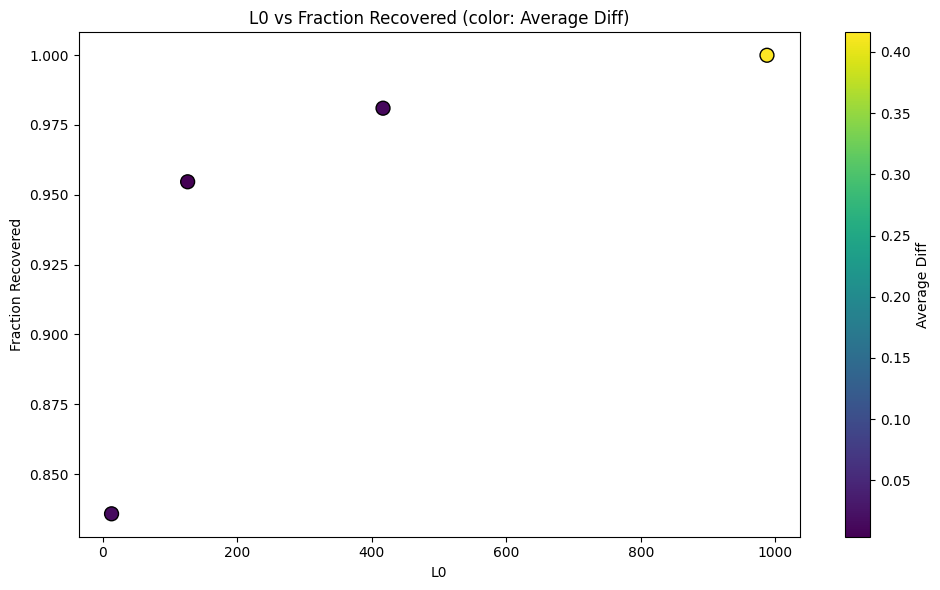

In [88]:
def plot_3var_graph(
    results: dict,
    xlims: Optional[tuple[float, float]] = None,
    y_lims: Optional[tuple[float, float]] = None,
    colorbar_label: str = "Average Diff",
    output_filename: Optional[str] = None,
):
    # Extract data from results
    l0_values = [data['l0'] for data in results.values()]
    frac_recovered_values = [data['frac_recovered'] for data in results.values()]
    average_diff_values = [data['average_diff'] for data in results.values()]

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a normalize object for color scaling
    norm = Normalize(vmin=min(average_diff_values), vmax=max(average_diff_values))

    # Plot data points
    scatter = ax.scatter(
        l0_values,
        frac_recovered_values,
        c=average_diff_values,
        cmap="viridis",
        s=100,
        norm=norm,
        edgecolor="black"
    )

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax, label=colorbar_label)

    # Set labels and title
    ax.set_xlabel("L0")
    ax.set_ylabel("Fraction Recovered")
    ax.set_title("L0 vs Fraction Recovered (color: Average Diff)")

    # Set axis limits
    if xlims:
        ax.set_xlim(*xlims)
    if y_lims:
        ax.set_ylim(*y_lims)

    plt.tight_layout()

    # Save and show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")
    plt.show()

# print(results)
if include_diff:
    plot_3var_graph(results)


In [89]:
import plotly.graph_objects as go
from typing import Optional, Dict, Any

def plot_interactive_3var_graph(
    results: Dict[str, Dict[str, float]],
    xlims: Optional[tuple[float, float]] = None,
    y_lims: Optional[tuple[float, float]] = None,
    output_filename: Optional[str] = None,
):
    # Extract data from results
    ae_paths = list(results.keys())
    l0_values = [data['l0'] for data in results.values()]
    frac_recovered_values = [data['frac_recovered'] for data in results.values()]

    third_value = [data['average_diff'] for data in results.values()]
    
    # Create the scatter plot
    fig = go.Figure()

    # Add trace
    fig.add_trace(go.Scatter(
        x=l0_values,
        y=frac_recovered_values,
        mode='markers',
        marker=dict(
            size=10,
            color=third_value,  # Color points based on frac_recovered
            colorscale='Viridis',  # You can change this colorscale
            showscale=True
        ),
        text=[f'AE Path: {ae}<br>L0: {l0:.4f}<br>Frac Recovered: {fr:.4f}<br>Average Diff: {ad:.4f}' 
              for ae, l0, fr, ad in zip(ae_paths, l0_values, frac_recovered_values, third_value)],
        hoverinfo='text'
    ))

    # Update layout
    fig.update_layout(
        title='L0 vs Fraction Recovered',
        xaxis_title='L0',
        yaxis_title='Fraction Recovered',
        hovermode='closest'
    )

    # Set axis limits
    if xlims:
        fig.update_xaxes(range=xlims)
    if y_lims:
        fig.update_yaxes(range=y_lims)

    # Save and show the plot
    if output_filename:
        fig.write_html(output_filename)
    
    fig.show()

# Example usage:
plot_interactive_3var_graph(results)

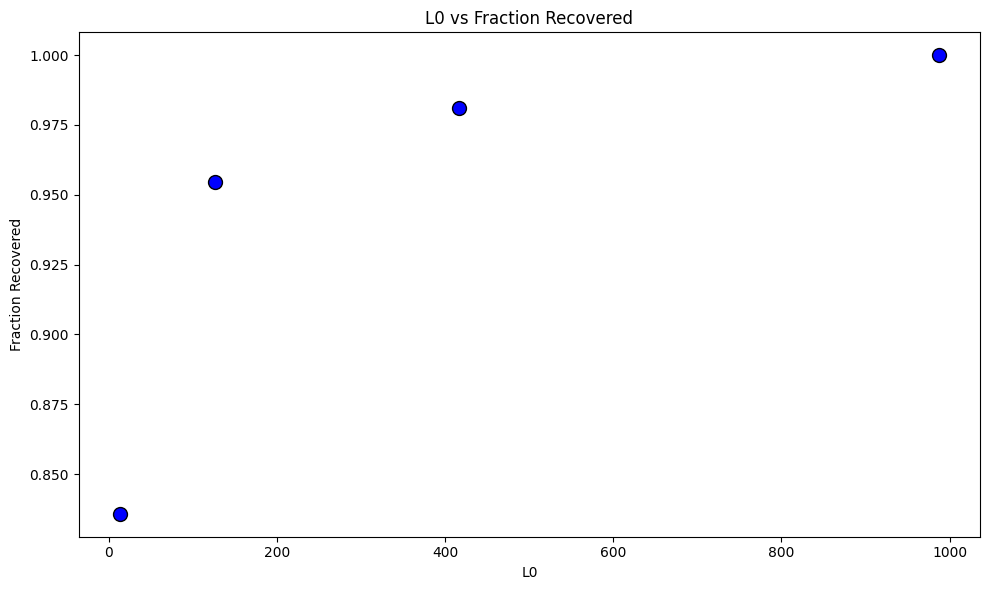

In [90]:
def plot_2var_graph(
    results: dict,
    xlims: Optional[tuple[float, float]] = None,
    y_lims: Optional[tuple[float, float]] = None,
    output_filename: Optional[str] = None,
):
    # Extract data from results
    l0_values = [data['l0'] for data in results.values()]
    frac_recovered_values = [data['frac_recovered'] for data in results.values()]

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data points
    ax.scatter(
        l0_values,
        frac_recovered_values,
        s=100,
        edgecolor="black",
        c="blue"  # You can change this color as needed
    )

    # Set labels and title
    ax.set_xlabel("L0")
    ax.set_ylabel("Fraction Recovered")
    ax.set_title("L0 vs Fraction Recovered")

    # Set axis limits
    if xlims:
        ax.set_xlim(*xlims)
    if y_lims:
        ax.set_ylim(*y_lims)

    plt.tight_layout()

    # Save and show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")
    plt.show()

# Example usage:
plot_2var_graph(results)